# Exploratory Data Analysis
Some simple EDA to get to know our dataset.

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
df = pd.read_csv('../data/HR_comma_sep.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
sales                    14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


## Looking at the values taken by the two non-numeric features:

In [3]:
print(df.sales.value_counts())
print('---')
print(df.salary.value_counts())

sales          4140
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: sales, dtype: int64
---
low       7316
medium    6446
high      1237
Name: salary, dtype: int64


## Comparing 'churn' among different departments:

In [4]:
positions = list(df.sales.value_counts().index)
for pos in positions:
    temp = df[df.sales == '{}'.format(pos)]
    print('Dept: {}'.format(pos))
    print('Churn Rate: {}'.format(temp['left'].sum()/temp.shape[0]))
    print('---')

Dept: sales
Churn Rate: 0.24492753623188407
---
Dept: technical
Churn Rate: 0.25625
---
Dept: support
Churn Rate: 0.2489905787348587
---
Dept: IT
Churn Rate: 0.22249388753056235
---
Dept: product_mng
Churn Rate: 0.21951219512195122
---
Dept: marketing
Churn Rate: 0.2365967365967366
---
Dept: RandD
Churn Rate: 0.15374841168996187
---
Dept: accounting
Churn Rate: 0.26597131681877445
---
Dept: hr
Churn Rate: 0.29093369418132614
---
Dept: management
Churn Rate: 0.14444444444444443
---


# A Couple Notes:

* The main takeaway here is that we are clearly dealing with imbalanced classes! We'll have to take this into consideration when building our model.  


* R & D and Management stick out as two departments with slightly less turnover, but likely not to the extent they deserve special, or exclusive consideration.  Let's simply consider inclusion in any of these departments (and salary scales) as a feature in our feature space.  Here, we use one hot encoding to reformat the departments as numeric features:

In [12]:
fs = pd.get_dummies(df, prefix=[None,'sal'],columns=['sales','salary'])
fs.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,IT,RandD,...,hr,management,marketing,product_mng,sales,support,technical,sal_high,sal_low,sal_medium
0,0.38,0.53,2,157,3,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0


## Let's try to get a sense of feature importance using a couple basic, out-of-box classifiers:

In [7]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE # This class from imbalanced-learning, a scikit-learn contrib package,
                           # uses the synthetic minority oversampling technique (SMOTE) to balance the classes. 

In [13]:
# Defining our target y, the 'left' column, and our feature space X.  Then we create train/test sets, and finally we
# fix our class imbalance problem with SMOTE resampling.

y = fs.pop('left')
X = fs

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=23)
X_train, y_train = SMOTE().fit_sample(X_train,y_train)

In [51]:
# Truly out of the box - all default parameters!

model_forest = RandomForestClassifier()
model_extra = ExtraTreesClassifier()
model_boost = AdaBoostClassifier()

models = [model_forest,model_extra,model_boost]

<Container object of 20 artists>

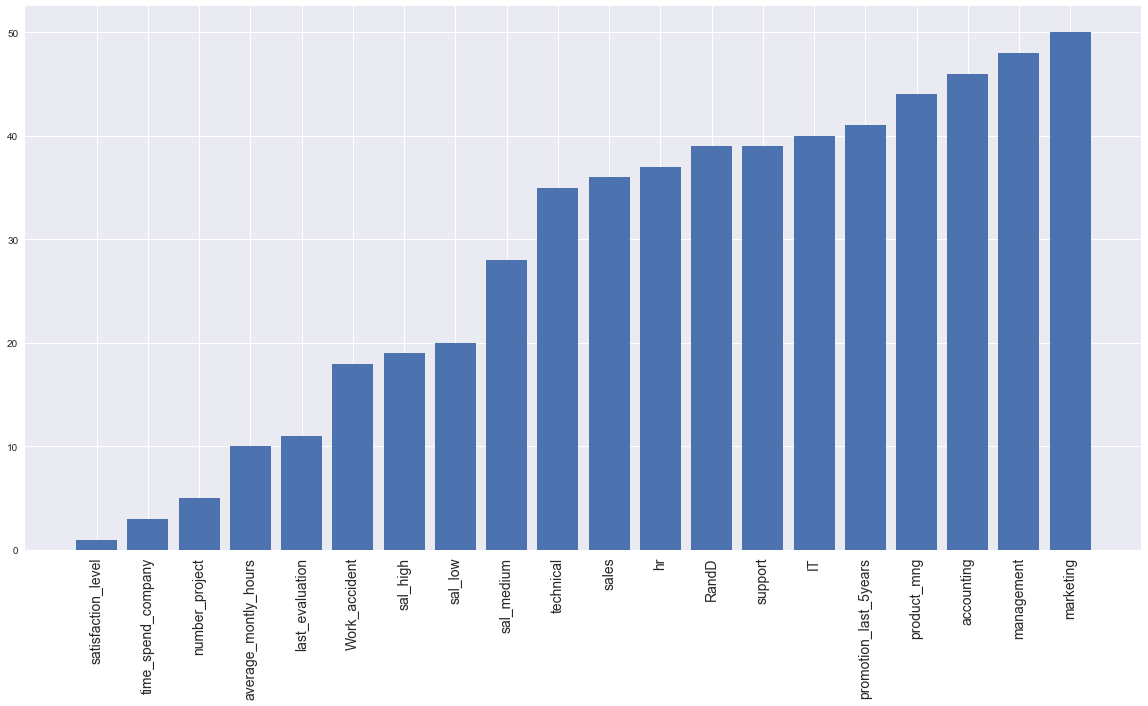

In [62]:
# This assigns a sort of "importance score" to each feature score by iteratively adding 

features_dict = {x:0 for x in fs.columns}

def get_feature_importances(model):
    model.fit(X_train,y_train)
    importances = np.argsort(model.feature_importances_)[::-1]
    for imp,idx in enumerate(importances):
        features_dict[fs.columns[idx]] += imp
for model in models:
    get_feature_importances(model)
    
x_axis = range(0,len(fs.columns))
features_dict = dict(sorted(features_dict.items(),key=lambda x: x[1]))

plt.figure(figsize=(20,10))
plt.xticks(x_axis,features_dict.keys(), rotation='vertical',fontsize=14)
plt.bar(x_axis,features_dict.values())

In [31]:
len(features_dict.values())

20

/Users/robertcorboy/anaconda/envs/py3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Users/robertcorboy/anaconda/envs/py3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


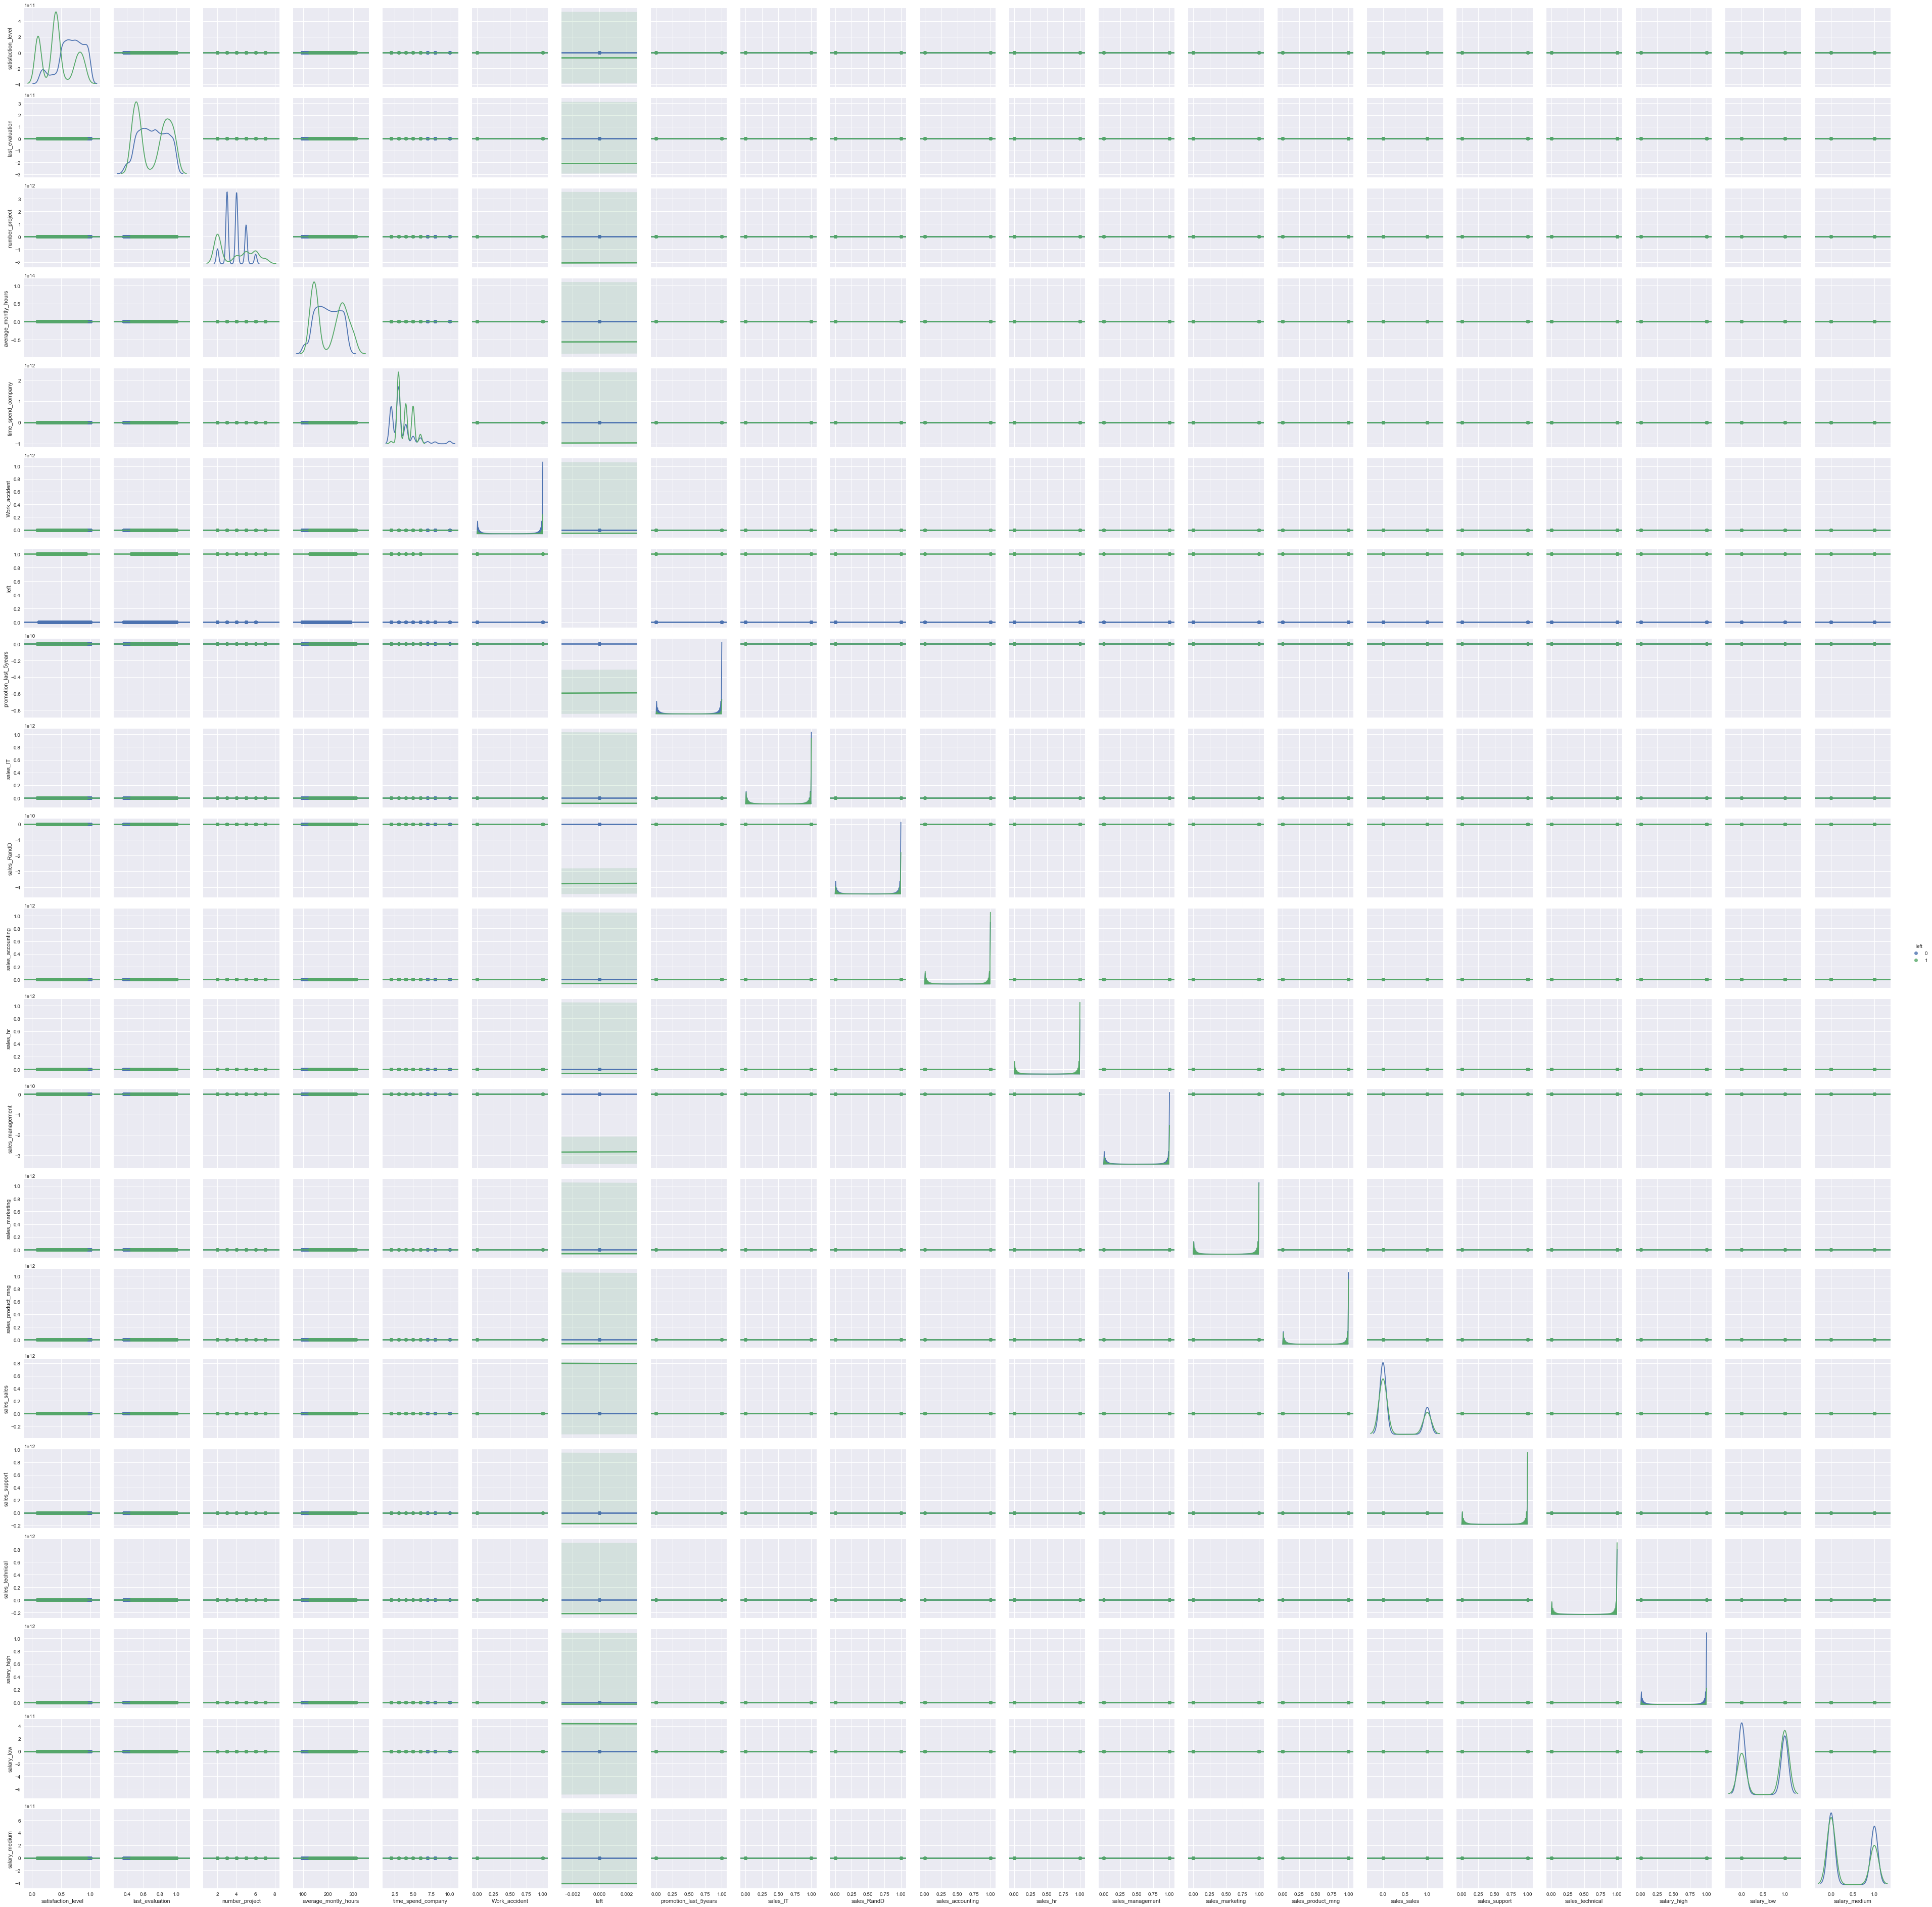

In [6]:
plot = sns.pairplot(fs,hue='left',diag_kind='kde',kind='reg')
